In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def cv_show(img):
    # 图像读取
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
img = cv2.imread("data/image/boat1.jpeg")

cv_show(img)

## 高斯金字塔

In [4]:
# 上采样
upSampling = cv2.pyrUp(img)

cv_show(upSampling)

In [5]:
# 下采样
downSampling = cv2.pyrDown(img)

cv_show(downSampling)

## 拉普拉斯金字塔

In [6]:
down = cv2.pyrDown(img)
down_up = cv2.pyrUp(down)
l_1 = img - down_up

cv_show(l_1)

## 图像轮廓

In [7]:
# cv2.findContours(img.mode, method)
# mode: 轮廓检测模式
#     RETR_EXTERNAL: 只检索最外面的轮廓；
#     RETR_LIST: 检索所有的轮廓，并将其保存到一条链表当中
#     RETR_CCOMP: 检索所有的轮廓，并将他们组织为两层；顶层是各部分的外部边界，第二层是空洞的边界
#     RETR_TREE: 检索所有的轮廓， 并重构嵌套轮廓的整个层次
# method: 轮廓逼近方法
#    CHAIN_APPROX_NONE: 以Freeman链码的方式输出轮廓，所有其他方法输出多边形（顶点的序列）
#    CHAIN_APPROX_SIMPLE: 压缩水平的、垂直的和斜的部分，也就是说函数只保留他们的终点部分
# 为了提高准确率，使用二值图像

# 先转灰度图，再进行阈值处理
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

cv_show(thresh)

In [8]:
# 检测所有的轮廓，画出所有的点
binary, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# 绘制轮廓,由于会覆盖原始图像，故须先拷贝
# 传入需绘制的图像，轮廓，轮廓索引(-1默认全部)，颜色模式，线条厚度
draw_img = img.copy()
res = cv2.drawContours(draw_img, contours, -1, (0, 0, 255), 2)

cv_show(res)

In [9]:
# 轮廓特征：面积、周长
cnt = contours[0]

cv2.contourArea(cnt)
cv2.arcLength(cnt, True)

2.0

In [10]:
# 轮廓近似, epsilon作为控制参数

epsilon = 0.1 * cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, epsilon, True)

draw_img = img.copy()
res = cv2.drawContours(draw_img, [approx], -1, (0, 0, 255), 2)

cv_show(res)

In [11]:
# 边界矩形, 找出轮廓的外接矩形
cnt = contours[0]

x, y, w, h = cv2.boundingRect(cnt)
recImg = cv2.rectangle(img, (x, y), (x+w, y+w), (0, 255, 0), 2)

cv_show(recImg)

In [12]:
# 计算轮廓面积与边界矩形比
cnt = contours[0]

area = cv2.contourArea(cnt)
x, y, w, h = cv2.boundingRect(cnt)

rect_area = w * h
extent = float(area) / rect_area

print(extent)

0.0


In [13]:
# 外接圆
cnt = contours[0]

(x, y), radius = cv2.minEnclosingCircle(cnt)
center = (int(x), int(y))
radius = int(radius)

cirImg = cv2.circle(img, center, radius, (0, 255, 0), 2)

cv_show(img)

## 模板匹配

In [14]:
img = cv2.imread("data/image/boat1.jpeg", 0)
template = cv2.imread("data/image/fog.jpg", 0)

h, w = template.shape[:2]

In [15]:
print("image.shape: ", img.shape)
print("template.shape: ", template.shape)

image.shape:  (612, 500)
template.shape:  (88, 62)


In [16]:
# TM_SQDIFF: 计算平方不同，值越小越相关
# TM_CCORR: 计算相关性，值越大越相关
# TM_CCOEFF: 计算相关系数，值越大越相关
# TM_SQDIFF_NORMED: 计算归一化平方不同，值接近0越相关
# TM_CCORR_NORMED: 计算归一化相关性，值越接近1越相关
# TM_CCOEFF_NORMED: 计算归一化系数，值越接近1越相关

methods = ['cv2.TM_SQDIFF', 'cv2.TM_CCORR', 'cv2.TM_CCOEFF', 
           'cv2.TM_SQDIFF_NORMED', 'cv2.TM_CCORR_NORMED', 'cv2.TM_CCOEFF_NORMED']

In [17]:
res = cv2.matchTemplate(img, template, 1)
print("res.shape: ", res.shape)

res.shape:  (525, 439)


In [18]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

print("min_val: ", min_val)
print("max_val: ", max_val)
print("min_loc: ", min_loc)
print("max_loc: ", max_loc)

min_val:  1.1371909749868792e-05
max_val:  1.0
min_loc:  (259, 31)
max_loc:  (153, 157)


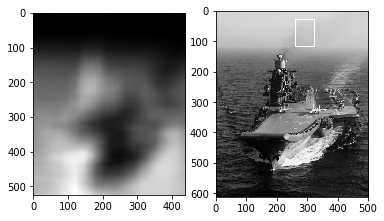

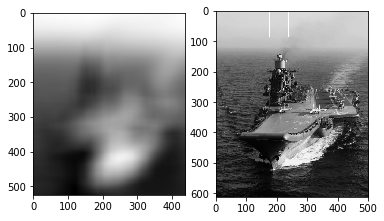

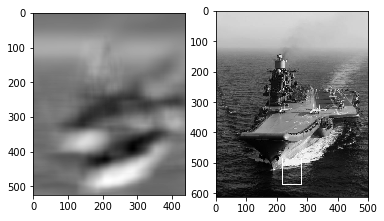

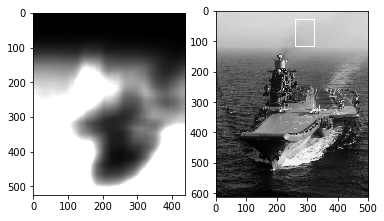

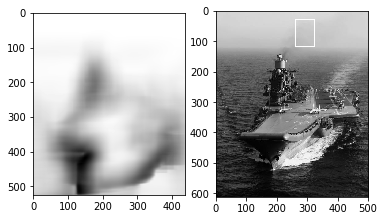

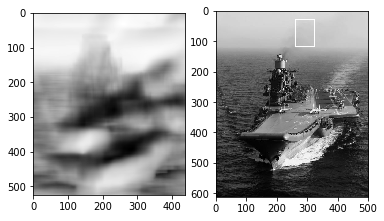

In [19]:
for method in methods:
    temp = img.copy()
    
    # 匹配方法的真值
    method = eval(method)
    res = cv2.matchTemplate(temp, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    # 根据方法取极值
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    # 画bounding box
    cv2.rectangle(temp, top_left, bottom_right, 255, 2)
    
    # 带归一化的效果都不会差
    plt.subplot(121)
    plt.imshow(res, cmap='gray')
    plt.subplot(122)
    plt.imshow(temp, cmap='gray')
    plt.show()

## 模板匹配多个对象

In [20]:
img_rgb = cv2.imread("data/image/boat1.jpeg")
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

template = cv2.imread("data/image/fog.jpg", 0)
h, w = template.shape[:2]

In [21]:
res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
threshold = 0.99

# 取匹配程度大于99%的坐标
loc = np.where(res >= threshold)

# 原图会被画框图覆盖
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + w, pt[1] + h)
    cv2.rectangle(img_rgb, pt, bottom_right, (0, 0, 255), 1)

cv_show(img_rgb)